<a href="https://colab.research.google.com/github/alousada/Capstone_Project/blob/main/00_final_assignment_coursera_final%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p>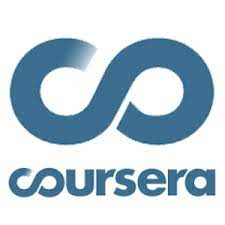</p>

<h1>Segmenting and Clustering Neighborhoods on São Paulo City</h1> <h1>The Best spot for a Brewery</h1>
<h2>Scraping the data from Internet</h2>

This script aim to select the hot points in São Paulo for brewery and beer related restaurants. The key objective is join enough data to assure best place for new beer business related shops in the city.

The main topics is: 

- Summarise the streets São Paulo city in a dataframe with postal codes and geo coordinates.
- Join a side dataframe with the streets names for all key beer stores in São Paulo.
- Select the places with higher citations on google.
- Apply a classification algorithm to group this places.
- Represent the results in a folium map.

Reference sites:

 São Paulo Streets : https://cep.guiamais.com.br/busca/sao+paulo-sp?page=1

 Beer places : https://www.listamais.com.br



# Install and import

## Install Libraries


In [ ]:
!pip install folium

In [ ]:
!pip install pycep_correios

     |████████████████████████████████| 100 kB 2.9 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 45 kB 2.1 MB/s 


In [ ]:
!pip install geopy

In [ ]:
pip install alive_progress

## Import Libraries

In [ ]:
import folium # plotting library
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle request

import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# tranforming json file into a pandas dataframe library
import json

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML
from IPython.display import display_html

#libraries for geolocation
import pycep_correios
import geopy
from geopy.geocoders import Nominatim

#Beatiful Soap
import json
import urllib3
from bs4 import BeautifulSoup
import pandas as pd
import requests

#progress bar
from alive_progress import alive_bar
from tqdm import tqdm

#time pause
from random import randint
from time import sleep

#google colab
from google.colab import files

print('Libraries imported.')

Libraries imported.


# All São Paulo Streets Data

## Import the document

In [ ]:
site_CP = 'https://cep.guiamais.com.br/busca/sao+paulo-sp?page='
CP_MAX  = 400

df_CP=pd.DataFrame()

for p in tqdm(range(1,CP_MAX)):
  df_ = pd.read_html(site_CP+str(p), encoding="utf-8")

  df = df_.pop(0)

  frames = [df_CP , df]

  df_CP = pd.concat(frames, sort=False)

df_CP.head()


 56%|█████▌    | 224/399 [12:53<04:34,  1.57s/it]

In [ ]:
df_CP

,LOGRADOURO,BAIRRO,CIDADE/ESTADO,BAIRRO.1,CEP
0,Rua 03 de Outubro (Ch Três Meninas),Jardim Helena,"São Paulo, SP","Jardim Helena, São Paulo, SP",08090-284
1,Rua 13 de Maio,Cantinho do Céu,"São Paulo, SP","Cantinho do Céu, São Paulo, SP",04849-529
2,Viela 16,Parque São José,"São Paulo, SP","Parque São José, São Paulo, SP",04843-425
3,Rua 18 de Abril,Cidade Antônio Estevão de Carvalho,"São Paulo, SP","Cidade Antônio Estevão de Carvalho, São Paulo, SP",08226-021
4,Travessa 19 de Agosto,Jardim Maria Estela,"São Paulo, SP","Jardim Maria Estela, São Paulo, SP",04180-112
...,...,...,...,...,...
20,Rua Campos de Guarapuava,Vila Zat,"São Paulo, SP","Vila Zat, São Paulo, SP",02976-140
21,Avenida Campos de Guaíra,Vila Nova Galvão,"São Paulo, SP","Vila Nova Galvão, São Paulo, SP",02280-040
22,Rua Campos de Lapa,Vila Rica,"São Paulo, SP","Vila Rica, São Paulo, SP",02861-000
23,Rua Campos de Maiorca,Jardim Aricanduva,"São Paulo, SP","Jardim Aricanduva, São Paulo, SP",03456-030


In [ ]:
df_CP.tail(10)

,LOGRADOURO,BAIRRO,CIDADE/ESTADO,BAIRRO.1,CEP
15,Rua Campos Verdes,Jardim Indaiá,"São Paulo, SP","Jardim Indaiá, São Paulo, SP",08143-380
16,Rua Campos Vergueiro,Vila Anastácio,"São Paulo, SP","Vila Anastácio, São Paulo, SP",05095-020
17,Via de Pedestre Campos,Jardim Beatriz,"São Paulo, SP","Jardim Beatriz, São Paulo, SP",04835-375
18,Viela Campos,Cidade Antônio Estevão de Carvalho,"São Paulo, SP","Cidade Antônio Estevão de Carvalho, São Paulo, SP",08223-361
19,Praça Campos da Cunha,Vila Ipojuca,"São Paulo, SP","Vila Ipojuca, São Paulo, SP",05054-130
20,Rua Campos de Guarapuava,Vila Zat,"São Paulo, SP","Vila Zat, São Paulo, SP",02976-140
21,Avenida Campos de Guaíra,Vila Nova Galvão,"São Paulo, SP","Vila Nova Galvão, São Paulo, SP",02280-040
22,Rua Campos de Lapa,Vila Rica,"São Paulo, SP","Vila Rica, São Paulo, SP",02861-000
23,Rua Campos de Maiorca,Jardim Aricanduva,"São Paulo, SP","Jardim Aricanduva, São Paulo, SP",03456-030
24,Rua Campos de Mesquita,Santo Amaro,"São Paulo, SP","Santo Amaro, São Paulo, SP",04744-020


In [ ]:
df_CP

,LOGRADOURO,BAIRRO,CIDADE/ESTADO,BAIRRO.1,CEP
0,Rua 03 de Outubro (Ch Três Meninas),Jardim Helena,"São Paulo, SP","Jardim Helena, São Paulo, SP",08090-284
1,Rua 13 de Maio,Cantinho do Céu,"São Paulo, SP","Cantinho do Céu, São Paulo, SP",04849-529
2,Viela 16,Parque São José,"São Paulo, SP","Parque São José, São Paulo, SP",04843-425
3,Rua 18 de Abril,Cidade Antônio Estevão de Carvalho,"São Paulo, SP","Cidade Antônio Estevão de Carvalho, São Paulo, SP",08226-021
4,Travessa 19 de Agosto,Jardim Maria Estela,"São Paulo, SP","Jardim Maria Estela, São Paulo, SP",04180-112
...,...,...,...,...,...
20,Rua Campos de Guarapuava,Vila Zat,"São Paulo, SP","Vila Zat, São Paulo, SP",02976-140
21,Avenida Campos de Guaíra,Vila Nova Galvão,"São Paulo, SP","Vila Nova Galvão, São Paulo, SP",02280-040
22,Rua Campos de Lapa,Vila Rica,"São Paulo, SP","Vila Rica, São Paulo, SP",02861-000
23,Rua Campos de Maiorca,Jardim Aricanduva,"São Paulo, SP","Jardim Aricanduva, São Paulo, SP",03456-030


### Scraping the Data

In [ ]:
df_CP[['Cidade', 'Estado']] = df['CIDADE/ESTADO'].str.split(',', expand=True)

df_CP['CEP'] = df_CP.CEP.replace('-', '', regex = True)

df_CP[['Location']]=df_CP['LOGRADOURO'] + ', ' + df_CP['Cidade'] + ', ' +  df_CP['BAIRRO'] + ' ' + df_CP['CEP'].map(str)

df_CP.head()


,LOGRADOURO,BAIRRO,CIDADE/ESTADO,BAIRRO.1,CEP,Cidade,Estado,Location
0,Rua 03 de Outubro (Ch Três Meninas),Jardim Helena,"São Paulo, SP","Jardim Helena, São Paulo, SP",08090284,São Paulo,SP,"Rua 03 de Outubro (Ch Três Meninas), São Paul..."
1,Rua 13 de Maio,Cantinho do Céu,"São Paulo, SP","Cantinho do Céu, São Paulo, SP",04849529,São Paulo,SP,"Rua 13 de Maio, São Paulo, Cantinho do Céu 048..."
2,Viela 16,Parque São José,"São Paulo, SP","Parque São José, São Paulo, SP",04843425,São Paulo,SP,"Viela 16, São Paulo, Parque São José 04843425"
3,Rua 18 de Abril,Cidade Antônio Estevão de Carvalho,"São Paulo, SP","Cidade Antônio Estevão de Carvalho, São Paulo, SP",08226021,São Paulo,SP,"Rua 18 de Abril, São Paulo, Cidade Antônio Est..."
4,Travessa 19 de Agosto,Jardim Maria Estela,"São Paulo, SP","Jardim Maria Estela, São Paulo, SP",04180112,São Paulo,SP,"Travessa 19 de Agosto, São Paulo, Jardim Maria..."


In [ ]:
#making an instance of Nominatim class
geolocator = Nominatim(user_agent="my_request")

l_latitude =[]
l_longitude=[]

for i in tqdm(range(0,len(df_CP))):
   try:
     loc=df_CP['Location'].iloc[i]
     location = geolocator.geocode(loc)
     latitude = location.latitude
     longitude= location.longitude
     l_latitude.append(latitude)
     l_longitude.append(longitude)
     #print((location.latitude , location.longitude))
   except:
     l_latitude.append(0)
     l_longitude.append(0)


 64%|██████▎   | 6357/9975 [52:59<29:34,  2.04it/s]

In [ ]:
df_CP['latitude'] = l_latitude
df_CP['longitude']= l_longitude


In [ ]:
df_CP.head(7)

In [ ]:
df_CP.to_excel("List_Postal_Codes_SP.xls")

## Load the Processed File - List_Postal_Codes_SP.xls

In [ ]:
df_CP = pd.read_excel("List_Postal_Codes_SP.xls")

# Beers Stores in São Paulo

## Import the Document

### Load the Data from Guia Mais

In [ ]:
def carrega(pag):
  site_txt="https://www.listamais.com.br/ResultadoBusca/PaginacaoPagina?vGlobalCidade=75&vGlobalBusca=cervejaria&vGlobalSize=10&vGlobalOrdem=melhor_resultado&vGlobalRestricoes=&vGlobalTipoRestricao=and&vGlobalCidadeDescricao=S%C3%A3o+Paulo++-+SP&vGlobalCampoTravado=0&vGlobalCursorAnterior=2&vGlobalCursorProximo=4&vGlobalCamposAceitos=todos&vGlobalQuantidadeDeRegistros=2250&vGlobalCampoTravadoDescricaoPaginacao=&vGlobalExibeh1=Cervejaria&vGlobalIntervalo=&vGlobalComecoPaginacao=10&sLocalizacao=&sCluster=&filtros=&segmento=&buscaES=true&buscaInfoCod=&total_paginas=225&pagina_atual=3&localizacaoUsuarioPaginacao=&cidadePaginacao=&proximo=col-md-12+NoPadding2%40ViewBag.proximo&usuarioPaginacao=0&random_ordem=0&sPagina="+str(pag)
  URL = (site_txt)
  page = requests.get(URL)
  soup = BeautifulSoup(page.content, "html.parser")
  job_elements = soup.find_all("script", type="application/ld+json")
  return job_elements

In [ ]:
pag=0
df=pd.DataFrame()
df_t=pd.DataFrame()

#try:

while pag<225:
  pag = pag + 1
  df=pd.concat([df,df_t])

  job_elements = carrega(pag)

  print(job_elements)

  # inital values - set up
  texto = str(job_elements)
  procura = '"name": "'
  s = 0
  frag = ""
  lista_n = []
  pos=0
  cond=','

  procura_l = ['"name": "',
                 '"addressLocality":"',
                 '"postalCode":"',
            '"streetAddress":"']
           

  col_nom   = ["Store_Name",
                 "Locality",
                 "Postal_Code",
              "Street_Address"]
             
  for i in range(0,len(procura_l)):

    procura = procura_l[i]

    print ("#"*50)
    print (procura)
    print (pag)
    print ("#"*50)

    while not(pos==-1):
      txt = ""
      frag = ""
      pos  = texto.find( procura , s )
      pos_ = pos + len(procura)

      while not(frag==cond):
        frag = texto[pos_:pos_+1]
        txt = txt + frag
        pos_ = pos_ + 1
  
      s=pos_
      txt.replace('",',"")
      lista_n.append(txt)

    df_t[col_nom[i]]=lista_n

    s=0
    frag = ""
    lista_n = []
    pos=0

    if i==2 :
      cond = '"' 
    else:
      cond = ','

    
#except:
#  print(pag)
#  pass


df.reset_index(inplace=True, drop=True)
df=pd.DataFrame(data=df, columns=col_nom)

df

A saída de streaming foi truncada nas últimas 5000 linhas.
            "@type": "ListItem",
            "position": 9,
            "url": "https://www.listamais.com.br/local/cad_id979XBQ/pet-shop-faro-fino-pet-shop-em-sao-paulo-sp",
            "item":
            {
            "@type": "LocalBusiness",
            "branchCode":"cad_id979148",
            "name": "Pet-shop Faro Fino ",
            "description": "Pet-shop Faro Fino  São Paulo  Pet Shop | Encontre na Lista Mais o Telefone, WhatsApp, Endereço, Avaliações e Como Chegar em Rua João Cândido Lima",
            "logo": "https://img-anuncio.listamais.com.br/imagens_anuncio/479333/destaque+na+busca+-+300x300.png",
            "image": "https://img-anuncio.listamais.com.br/imagens_anuncio/479333/destaque+na+busca+-+300x300.png",
            "address": [{"@type":"PostalAddress",
            "addressLocality":"São Paulo ",
            "addressRegion":"SP",
            "postalCode":"03678-020",
            "streetAddress":"Rua João

,Store_Name,Locality,Postal_Code,Street_Address
0,"Ilha do Chopp "",","São Paulo "",","46619-03 "",","Avenida Interlagos, 2255, """
1,"Pizzaria Choperia Favo Dmel Ltda Epp "",","São Paulo "",",""",","Travessa Tupi, 60, Sta Cecília"""
2,"Cervejaria Petrópolis S/a "",","São Paulo "",",""",","Avenida Doutor Assis Ribeiro, 5203, Erm Matar..."
3,"Cervejaria Mauri Ltda "",","São Paulo "",","01448-000"",","Rua Amauri, 334, Jd Europa"""
4,"J F Rest Pizzaria Choperia Ltda Me "",","São Paulo "",","02243-010"",","Rua Paulo Avelar, 127, Fr Vl Dom Pedro Ii"""
...,...,...,...,...
2459,"Qg Auto Shop - Jd Peri Peri "",","São Paulo "",",""",","Rua Salvado Isoleu, 85, """
2460,Universal Distribuidora de Maçanetas e Ferrage...,"São Paulo "",",""",","Rua Belamino José Costa, 19, """
2461,"Triplicar Auto Shop "",","São Paulo "",",""",","Av Guapira, 1650, Bro Vl Constanca """
2462,"W W Auto Shop "",","São Paulo "",","21250-00 "",","Rua Mere Amedea, 90, """


### Cleasing and Pre Processing the Data

In [ ]:
# Remove not valide rows

for i in range(0,df.shape[0]):
  proc=str(df['Store_Name'].loc[i:i])
  if proc[0:18+len(str(i))] == str(i)+'     type="applica':
    df['Store_Name'].loc[i:i]="deletar"

df.drop(df[df['Store_Name'] == "deletar"].index, inplace = True)
df.reset_index(inplace=True, drop=True)

df


,Store_Name,Locality,Postal_Code,Street_Address
0,"Café Terraço "",","São Paulo "",","47950-00 "",","Avenida Nações Unidas, 22178, """
1,"Dunnas Pizza Frita Bar "",","São Paulo "",","37331-80 "",","Rua Doutor Virgílio Machado, 104, """
2,"Cervejaria Tradicional Ltda e "",","São Paulo "",","05022-000"",","Avenida Pompéia, 600, Vl Pompéia"""
3,"Choperia do Sacha "",","São Paulo "",","54350-00 "",","Rua Harmonia, 472, """
4,"Restaurante Choperia Tche Gaúcho Ltda "",","São Paulo "",",""",","Estrada Guarapiranga, 884, Guarapiranga"""
...,...,...,...,...
2235,"Shop Car Moraes Serviços Automotivos S/c "",","São Paulo "",",""",","Rua Odovalho Jr, 475, """
2236,"Qg Auto Shop - Jd Peri Peri "",","São Paulo "",",""",","Rua Salvado Isoleu, 85, """
2237,Universal Distribuidora de Maçanetas e Ferrage...,"São Paulo "",",""",","Rua Belamino José Costa, 19, """
2238,"Triplicar Auto Shop "",","São Paulo "",",""",","Av Guapira, 1650, Bro Vl Constanca """


In [ ]:
# Cleanning Data

street=""
number=""
neighb=""

street_l=[]
number_l=[]
neighb_l=[]

for i in range(0,df.shape[0]):
  proc=str(df['Street_Address'].loc[i:i])
  proc_=proc.split(sep=",")

  if not(len(proc_)==4):
    df['Street_Address'].loc[i:i]="deletar"

df.drop(df[df['Street_Address'] == "deletar"].index, inplace = True)
df.reset_index(inplace=True, drop=True)

df

,Store_Name,Locality,Postal_Code,Street_Address
0,"Café Terraço "",","São Paulo "",","47950-00 "",","Avenida Nações Unidas, 22178, """
1,"Dunnas Pizza Frita Bar "",","São Paulo "",","37331-80 "",","Rua Doutor Virgílio Machado, 104, """
2,"Cervejaria Tradicional Ltda e "",","São Paulo "",","05022-000"",","Avenida Pompéia, 600, Vl Pompéia"""
3,"Choperia do Sacha "",","São Paulo "",","54350-00 "",","Rua Harmonia, 472, """
4,"Restaurante Choperia Tche Gaúcho Ltda "",","São Paulo "",",""",","Estrada Guarapiranga, 884, Guarapiranga"""
...,...,...,...,...
2229,"Shop Car Moraes Serviços Automotivos S/c "",","São Paulo "",",""",","Rua Odovalho Jr, 475, """
2230,"Qg Auto Shop - Jd Peri Peri "",","São Paulo "",",""",","Rua Salvado Isoleu, 85, """
2231,Universal Distribuidora de Maçanetas e Ferrage...,"São Paulo "",",""",","Rua Belamino José Costa, 19, """
2232,"Triplicar Auto Shop "",","São Paulo "",",""",","Av Guapira, 1650, Bro Vl Constanca """


In [ ]:
# Detailing Address

df[[ 'Street_Name', 'Number', 'Neighborhood' ]] = df['Street_Address'].str.split(',', expand=True)

df

,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood
0,"Café Terraço "",","São Paulo "",","47950-00 "",","Avenida Nações Unidas, 22178, """,Avenida Nações Unidas,22178,""""
1,"Dunnas Pizza Frita Bar "",","São Paulo "",","37331-80 "",","Rua Doutor Virgílio Machado, 104, """,Rua Doutor Virgílio Machado,104,""""
2,"Cervejaria Tradicional Ltda e "",","São Paulo "",","05022-000"",","Avenida Pompéia, 600, Vl Pompéia""",Avenida Pompéia,600,"Vl Pompéia"""
3,"Choperia do Sacha "",","São Paulo "",","54350-00 "",","Rua Harmonia, 472, """,Rua Harmonia,472,""""
4,"Restaurante Choperia Tche Gaúcho Ltda "",","São Paulo "",",""",","Estrada Guarapiranga, 884, Guarapiranga""",Estrada Guarapiranga,884,"Guarapiranga"""
...,...,...,...,...,...,...,...
2229,"Shop Car Moraes Serviços Automotivos S/c "",","São Paulo "",",""",","Rua Odovalho Jr, 475, """,Rua Odovalho Jr,475,""""
2230,"Qg Auto Shop - Jd Peri Peri "",","São Paulo "",",""",","Rua Salvado Isoleu, 85, """,Rua Salvado Isoleu,85,""""
2231,Universal Distribuidora de Maçanetas e Ferrage...,"São Paulo "",",""",","Rua Belamino José Costa, 19, """,Rua Belamino José Costa,19,""""
2232,"Triplicar Auto Shop "",","São Paulo "",",""",","Av Guapira, 1650, Bro Vl Constanca """,Av Guapira,1650,"Bro Vl Constanca """


In [ ]:
# Polishing data

df['Store_Name'] = df.Store_Name.replace('",', '', regex = True)

df['Locality'] = df.Locality.replace('",', '', regex = True)

df['Postal_Code'] = df.Postal_Code.replace('",', '', regex = True)

df['Street_Address'] = df.Street_Address.replace('"', '', regex = True)

df['Neighborhood'] = df.Neighborhood.replace('"', '', regex = True)

df

,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood
0,Café Terraço,São Paulo,47950-00,"Avenida Nações Unidas, 22178,",Avenida Nações Unidas,22178,
1,Dunnas Pizza Frita Bar,São Paulo,37331-80,"Rua Doutor Virgílio Machado, 104,",Rua Doutor Virgílio Machado,104,
2,Cervejaria Tradicional Ltda e,São Paulo,05022-000,"Avenida Pompéia, 600, Vl Pompéia",Avenida Pompéia,600,Vl Pompéia
3,Choperia do Sacha,São Paulo,54350-00,"Rua Harmonia, 472,",Rua Harmonia,472,
4,Restaurante Choperia Tche Gaúcho Ltda,São Paulo,,"Estrada Guarapiranga, 884, Guarapiranga",Estrada Guarapiranga,884,Guarapiranga
...,...,...,...,...,...,...,...
2229,Shop Car Moraes Serviços Automotivos S/c,São Paulo,,"Rua Odovalho Jr, 475,",Rua Odovalho Jr,475,
2230,Qg Auto Shop - Jd Peri Peri,São Paulo,,"Rua Salvado Isoleu, 85,",Rua Salvado Isoleu,85,
2231,Universal Distribuidora de Maçanetas e Ferrage...,São Paulo,,"Rua Belamino José Costa, 19,",Rua Belamino José Costa,19,
2232,Triplicar Auto Shop,São Paulo,,"Av Guapira, 1650, Bro Vl Constanca",Av Guapira,1650,Bro Vl Constanca


## Selecting the Stores

In [ ]:
def browse(text,i):

  import requests
  import bs4
  
  # Fetch the URL data using requests.get(url),
  #url = 'https://google.com/search?q=' + text
  url = 'https://br.search.yahoo.com/search?p=' + text

  # Fetch the URL data using requests.get(url),
  # store it in a variable, request_result.
  request_result=requests.get( url )
  sleep(randint(0,2))
  
  # Creating soup from the fetched request
  soup = bs4.BeautifulSoup(request_result.text,
                         "html.parser")
  
  if i/300==int(i/300):
    sleep(randint(5*60,8*60))

  return soup


In [ ]:
def minhash(input_question, compare_question):
    score = 0.0

    # calculate the jaccard distance
    shingles = lambda s: set(s[i:i+3] for i in range(len(s)-2))
    jaccard_distance = lambda seta, setb: len(seta & setb)/float(len(seta | setb))
    try:
        score = jaccard_distance(shingles(input_question), shingles(compare_question))
    except ZeroDivisionError:
        print('ZeroDivisionError')

    return score

In [ ]:
# Pre-filter - excluding the stores not directly related to the brewery segment

# Remove not valide rows

exclude_KW = ["pet ",
              "sex ",
              "posto ",
              "shop ",
              "pet-shop"
              ]

ini=df.shape[0]

for k in tqdm(range(0,len(exclude_KW))):

  for i in range(0,df.shape[0]):
    proc=str(df['Store_Name'].loc[i:i]).lower()

    if proc.find(exclude_KW[k]) != -1:
      df['Store_Name'].loc[i:i]="deletar"

df.drop(df[df['Store_Name'] == "deletar"].index, inplace = True)
df.reset_index(inplace=True, drop=True)

fin=df.shape[0]

print(f"Percentual de redução de {(1-fin/ini)*100} %")

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 5/5 [00:06<00:00,  1.22s/it]

Percentual de redução de 69.51656222023277 %


In [ ]:
key_words = 'cerveja beer artesanal cervejaria'
text=""
minhash_l=[]
count_f=[]
score_f=[]

opt_keyw    = ["cerveja","cervejaria","boas cervejas"]
opt_nam_col = ["geral_1","geral_2","espec_1"]


k=1
while k<3:

  for j in tqdm(range(df.shape[0])):

    score_l_médio=0
    score_l=[]
    count=0

    key_word=opt_keyw[k]

    text = '"' + str(df["Store_Name"].loc[j:j]) + " " + str(df["Locality"].loc[j:j]) + " " + key_word + '"'
    soup = browse(text,j)
  
    # soup.find.all( h3 ) to grab 
    heading_object=soup.find_all( 'h3' )
  
    # take all h3 
    results=[]
    for info in heading_object:
      results.append(info.getText())

    # number of citations
    count = len(results)
    count_f.append(count)

    #score of similarity 
    for l in range(1, len(results)):
      score_t=minhash(results[l] , key_words)
      score_l.append(score_t)

      if len(score_l)==0:
        score_l_médio=0
      else:
        score_l_médio = sum(score_l)/len(score_l)
  
    score_f.append(score_l_médio)

    if j/300 == int(j/300):
      print(score_f)
  
  name_1 = "Num_oc_" + opt_nam_col[k]
  name_2 = "Sscore_" + opt_nam_col[k]


  df[name_1] = count_f
  df[name_2] = score_f

  count_f=[]
  score_f=[]

  k=k+1

  df.to_excel('Cervejarias em Sampa.xlsx')

  files.download('Cervejarias em Sampa.xlsx')



  0%|          | 1/681 [05:14<59:27:07, 314.75s/it]

[0.00623613154254827]


 44%|████▍     | 301/681 [20:13<13:39:30, 129.40s/it]

[0.00623613154254827, 0.006404702369137407, 0.029811476776340214, 0.0038742264769662032, 0.00803679496489954, 0.005344883292461276, 0.0, 0.015271472031952, 0.0, 0.0, 0.016474059584454425, 0.007401965359568187, 0.0, 0.004554911847985357, 0.005267686099015539, 0.0, 0.00321835286350883, 0.0, 0.001814142910033321, 0.006640498748499807, 0.00623613154254827, 0.002682788588702059, 0.002564102564102564, 0.003527336860670194, 0.013157894736842105, 0.10528702709153837, 0.0025, 0, 0.015674185552030852, 0.012048192771084338, 0.008529589594608544, 0.011480333960142272, 0.007833255196124395, 0.0038661468486029887, 0.0, 0.0010964912280701754, 0.014351365623381277, 0.0036910457963089537, 0.00292564578278864, 0.0, 0.0, 0.006045173823403346, 0.00393514108974283, 0.003615944711835123, 0.002147809910366988, 0.01105879425994783, 0.005968996465125557, 0.01878529666314196, 0.0, 0.007357016880826404, 0.0, 0.0, 0.025655123133525123, 0.014658865146879937, 0.004115226337448559, 0.009525986196608376, 0.0228818800

 88%|████████▊ | 601/681 [33:40<2:17:22, 103.03s/it]

[0.00623613154254827, 0.006404702369137407, 0.029811476776340214, 0.0038742264769662032, 0.00803679496489954, 0.005344883292461276, 0.0, 0.015271472031952, 0.0, 0.0, 0.016474059584454425, 0.007401965359568187, 0.0, 0.004554911847985357, 0.005267686099015539, 0.0, 0.00321835286350883, 0.0, 0.001814142910033321, 0.006640498748499807, 0.00623613154254827, 0.002682788588702059, 0.002564102564102564, 0.003527336860670194, 0.013157894736842105, 0.10528702709153837, 0.0025, 0, 0.015674185552030852, 0.012048192771084338, 0.008529589594608544, 0.011480333960142272, 0.007833255196124395, 0.0038661468486029887, 0.0, 0.0010964912280701754, 0.014351365623381277, 0.0036910457963089537, 0.00292564578278864, 0.0, 0.0, 0.006045173823403346, 0.00393514108974283, 0.003615944711835123, 0.002147809910366988, 0.01105879425994783, 0.005968996465125557, 0.01878529666314196, 0.0, 0.007357016880826404, 0.0, 0.0, 0.025655123133525123, 0.014658865146879937, 0.004115226337448559, 0.009525986196608376, 0.0228818800

100%|██████████| 681/681 [35:49<00:00,  3.16s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 1/681 [05:54<66:58:46, 354.60s/it]

[0.005325627434176073]


 44%|████▍     | 301/681 [19:13<10:39:03, 100.90s/it]

[0.005325627434176073, 0.0046359206686300836, 0.024022567952063822, 0.003615944711835123, 0.00803679496489954, 0.005436474309526414, 0.007779809421140572, 0.014544256100465974, 0.0, 0.0, 0.017446493750096558, 0.012693871169480925, 0.0009784735812133072, 0.003615944711835123, 0.0, 0.002631578947368421, 0.0017123287671232876, 0.05454545454545454, 0.0, 0.008574979287489643, 0.00798569611009906, 0.00443717455361434, 0.0, 0.003527336860670194, 0.002631578947368421, 0.061224489795918366, 0.0, 0.004708116443829349, 0.007697577364896347, 0, 0.002702702702702703, 0.0025257397435672567, 0.009357645440026834, 0.0, 0.012906725688680575, 0.0029683953204120836, 0.0, 0.007998599358559748, 0.003289129171482113, 0.006250488954559029, 0.0017543859649122805, 0.007266439703016414, 0.011299435028248588, 0.0, 0.004850512613069691, 0.014431268151287547, 0, 0.010127103567652103, 0.0, 0.007357016880826404, 0.0026881720430107525, 0, 0.09333333333333334, 0.01950897735583795, 0.008328102113412847, 0.0074008740533

 88%|████████▊ | 601/681 [34:05<2:42:57, 122.22s/it]

[0.005325627434176073, 0.0046359206686300836, 0.024022567952063822, 0.003615944711835123, 0.00803679496489954, 0.005436474309526414, 0.007779809421140572, 0.014544256100465974, 0.0, 0.0, 0.017446493750096558, 0.012693871169480925, 0.0009784735812133072, 0.003615944711835123, 0.0, 0.002631578947368421, 0.0017123287671232876, 0.05454545454545454, 0.0, 0.008574979287489643, 0.00798569611009906, 0.00443717455361434, 0.0, 0.003527336860670194, 0.002631578947368421, 0.061224489795918366, 0.0, 0.004708116443829349, 0.007697577364896347, 0, 0.002702702702702703, 0.0025257397435672567, 0.009357645440026834, 0.0, 0.012906725688680575, 0.0029683953204120836, 0.0, 0.007998599358559748, 0.003289129171482113, 0.006250488954559029, 0.0017543859649122805, 0.007266439703016414, 0.011299435028248588, 0.0, 0.004850512613069691, 0.014431268151287547, 0, 0.010127103567652103, 0.0, 0.007357016880826404, 0.0026881720430107525, 0, 0.09333333333333334, 0.01950897735583795, 0.008328102113412847, 0.0074008740533

100%|██████████| 681/681 [36:19<00:00,  3.20s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Save the final file

In [ ]:
df.to_excel("Cervejarias em Sampa.xlsx")

## Load the Processed File - Cervejarias em Sampa.xls

In [ ]:
df = pd.read_excel("Cervejarias em Sampa.xlsx")

df.drop("Unnamed: 0", inplace=True, axis=1)

In [ ]:
df.columns = ["Store_Name", "Locality", "Postal_Code", "Street_Address"]

In [ ]:
df

,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood,Num_oc_geral_1,Sscore_geral_1
0,Café Terraço,São Paulo,47950-00,"Avenida Nações Unidas, 22178,",Avenida Nações Unidas,22178,,14,0.007280
1,Dunnas Pizza Frita Bar,São Paulo,37331-80,"Rua Doutor Virgílio Machado, 104,",Rua Doutor Virgílio Machado,104,,14,0.005305
2,Cervejaria Tradicional Ltda e,São Paulo,05022-000,"Avenida Pompéia, 600, Vl Pompéia",Avenida Pompéia,600,Vl Pompéia,14,0.005354
3,Choperia do Sacha,São Paulo,54350-00,"Rua Harmonia, 472,",Rua Harmonia,472,,14,0.006197
4,Restaurante Choperia Tche Gaúcho Ltda,São Paulo,NaN,"Estrada Guarapiranga, 884, Guarapiranga",Estrada Guarapiranga,884,Guarapiranga,3,0.018221
...,...,...,...,...,...,...,...,...,...
2229,Shop Car Moraes Serviços Automotivos S/c,São Paulo,NaN,"Rua Odovalho Jr, 475,",Rua Odovalho Jr,475,,1,0.000000
2230,Qg Auto Shop - Jd Peri Peri,São Paulo,NaN,"Rua Salvado Isoleu, 85,",Rua Salvado Isoleu,85,,0,0.000000
2231,Universal Distribuidora de Maçanetas e Ferrage...,São Paulo,NaN,"Rua Belamino José Costa, 19,",Rua Belamino José Costa,19,,10,0.003295
2232,Triplicar Auto Shop,São Paulo,NaN,"Av Guapira, 1650, Bro Vl Constanca",Av Guapira,1650,Bro Vl Constanca,0,0.000000


In [ ]:
files.download('Cervejarias em Sampa.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>